# 장애인 콜택시 대기시간 예측 프로젝트 데이터 처리
## 목표
- 기상 예보를 바탕으로, 장애인 콜택시 평균 대기 시간을 예측하기.
- 장애인 이동권 개선을 위하여서, 콜택시 대기시간을 예측하는 프로젝트이다.  
- 이를 통하여 장애인 콜택시를 이용하는 고객들의 불편사항을 개선하고 서비스의 품질을 높여 교통약자의 이동 편의 증진에 기여한다.
### 목차
1. 데이터 처리  
2. 데이터 분석
3. **머신러닝 모델링**   
    - (나머지 3달 데이터는 테스트, 나머지는 학습데이터로 활용)  
    - MAE, MAPE를 사용해 성능 높은 모델 선정  
- 데이터 출처 : [서울시설공단_장애인콜택시 일별 이용현황](https://www.data.go.kr/data/15057705/openapi.do)  

## 라이브러리 불러오기

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 회귀 모델
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 회귀 성능 튜닝
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# 회귀 평가
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

# 딥러닝
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore') # pd 경고메시지 생략

## 데이터 불러오기

In [2]:
# df = pd.read_csv('./data/df.csv')
df = joblib.load('./data/df.pkl')
df.head()

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday,7days_waiting_time
time,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,2015,1,1,3,1.0,NaN
2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,2015,1,1,4,0.0,NaN
2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,2015,1,1,5,1.0,NaN
2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,2015,1,1,6,1.0,NaN
2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,2015,1,2,0,0.0,NaN


#### NaN 값 처리, 타입 변경하기

In [3]:
drop_col = '7days_waiting_time'
df = df.drop(drop_col, axis=1)

In [4]:
df['weekday'] = df['weekday'].astype('int') # 해당 코드 진행시 변경이 안됌

In [5]:
df = df.astype('float')

In [6]:
df

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday
time,,,,,,,,,,,,,,,,,
2015-01-01,213.0,1023.0,924.0,23.2,2427.0,10764.0,-2.0,-8.9,0.0,63.0,28.0,9.07,2015.0,1.0,1.0,3.0,1.0
2015-01-02,420.0,3158.0,2839.0,17.2,2216.0,8611.0,2.4,-9.2,0.0,73.0,37.0,8.66,2015.0,1.0,1.0,4.0,0.0
2015-01-03,209.0,1648.0,1514.0,26.2,2377.0,10198.0,8.2,0.2,0.0,89.0,58.0,5.32,2015.0,1.0,1.0,5.0,1.0
2015-01-04,196.0,1646.0,1526.0,24.5,2431.0,10955.0,7.9,-0.9,0.0,95.0,52.0,6.48,2015.0,1.0,1.0,6.0,1.0
2015-01-05,421.0,4250.0,3730.0,26.2,2214.0,8663.0,4.1,-7.4,3.4,98.0,29.0,10.47,2015.0,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,669.0,5635.0,4654.0,44.4,2198.0,8178.0,-0.3,-5.4,0.1,92.0,40.0,10.86,2022.0,12.0,52.0,1.0,0.0
2022-12-28,607.0,5654.0,4648.0,44.8,2161.0,7882.0,1.7,-7.8,0.0,71.0,34.0,10.88,2022.0,12.0,52.0,2.0,0.0
2022-12-29,581.0,5250.0,4247.0,52.5,2229.0,8433.0,2.1,-4.0,0.0,87.0,38.0,10.84,2022.0,12.0,52.0,3.0,0.0


# 데이터 나누기
* 시계열 데이터 특성에 맞게 분할  
* 마지막 91일(3개월) 데이터를 검증셋으로 사용

#### x,y 분리하기

In [123]:
target = 'waiting_time'

x = df.drop(target, axis=1)
y = df.loc[:,target]

In [32]:
display(x.head(2))
display(y.head(2))

,car_cnt,request_cnt,ride_cnt,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday
time,,,,,,,,,,,,,,,,
2015-01-01,213.0,1023.0,924.0,2427.0,10764.0,-2.0,-8.9,0.0,63.0,28.0,9.07,2015.0,1.0,1.0,3.0,1.0
2015-01-02,420.0,3158.0,2839.0,2216.0,8611.0,2.4,-9.2,0.0,73.0,37.0,8.66,2015.0,1.0,1.0,4.0,0.0


time
2015-01-01    23.2
2015-01-02    17.2
Name: waiting_time, dtype: float64

In [9]:
y.head(2)

time
2015-01-01    23.2
2015-01-02    17.2
Name: waiting_time, dtype: float64

#### train, validation 나누기

In [126]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x.iloc[:,:11],y, test_size= 92, shuffle=False)

#### 정규화
- knn 사용을 위해서

In [127]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_train)

# 데이터 모델링

- MAE, MAPE로 성능 측정
- MAE와 MAPE는 모두 값이 작을수록 모델의 성능이 좋다는 것을 의미한다.

## ML

#### ML모델 선언

In [128]:
LR_model = LinearRegression()
KN_model = KNeighborsRegressor()
Tree_model = DecisionTreeRegressor()
RanF_model = RandomForestRegressor()
xg_model = XGBRegressor()
lg_model = LGBMRegressor()

models = {'LR_model':LR_model,
        'KN_model':KN_model,
        'Tree_model':Tree_model,
        'RanF_model':RanF_model,
        'xg_model':xg_model,
        'lg_model':lg_model}

In [132]:
m = LR_model.fit(x_train, y_train)
y_pred = m.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2:', r2_score(y_test, y_pred))


MAE: 3.221268090046439
MAPE: 0.07781566445420972
r2: 0.5619886499197603


#### 모델 학습 및 평가

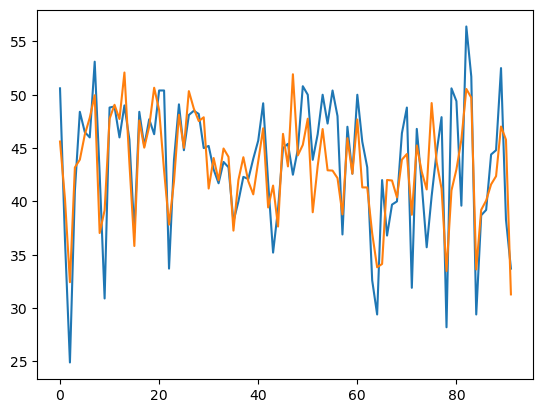

LR_model
MAE: 3.221268090046439
MAPE: 0.07781566445420972
r2: 0.5619886499197603


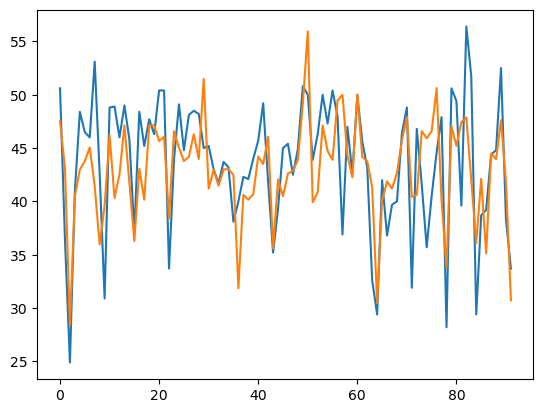

KN_model
MAE: 3.869347826086957
MAPE: 0.09227576659381302
r2: 0.37923278597131427


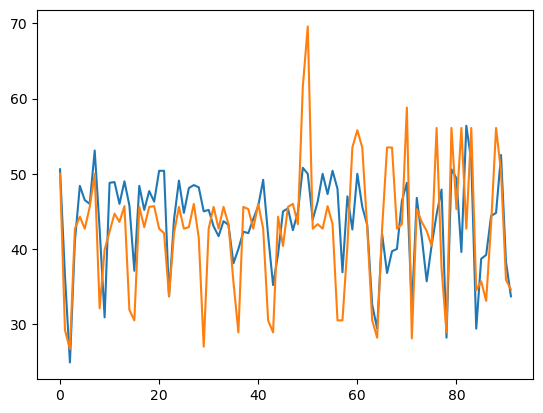

Tree_model
MAE: 5.229347826086956
MAPE: 0.12027563185418774
r2: -0.3044319852009534


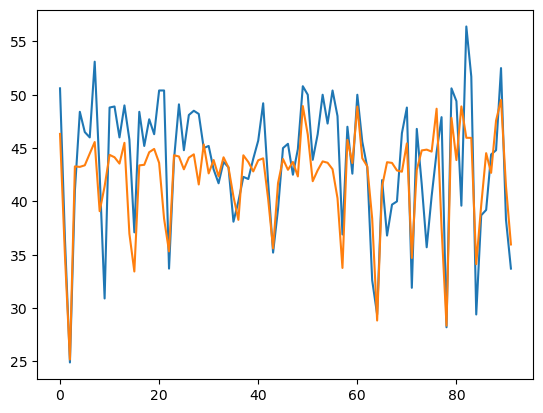

RanF_model
MAE: 3.4819239130434787
MAPE: 0.07955780396073925
r2: 0.4853293639830718


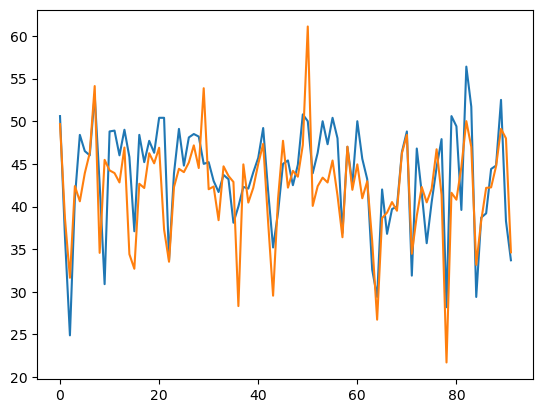

xg_model
MAE: 3.7126105308532718
MAPE: 0.08745739587411139
r2: 0.3650760178088893
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 2831, number of used features: 11
[LightGBM] [Info] Start training from score 40.192794


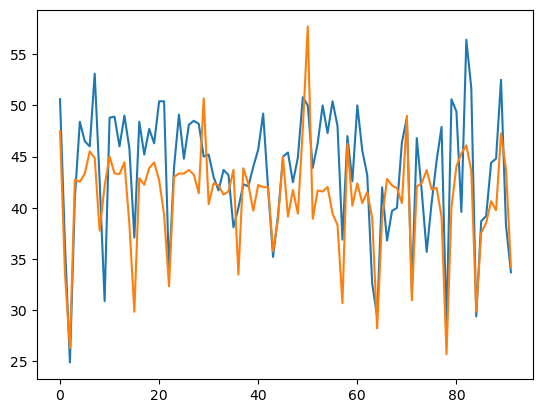

lg_model
MAE: 4.224519178662882
MAPE: 0.095252104058292
r2: 0.28834934695950076


In [133]:
results = []
for name, model in models.items():
    print("="*50)
    if model != 'KN_model':
        model.fit(x_train, y_train) # 모델 학습
        y_pred = model.predict(x_test) # 모델 예측
        model_mae = mae(y_test, y_pred)
        model_mape = mape(y_test, y_pred)
        model_r2 = r2_score(y_test, y_pred)
    else:
        model.fit(x_train_s, y_train)
        y_pred = model.predict(x_test_s)
        model_mae = mae(y_test, y_pred)
        model_mape = mape(y_test, y_pred)
        model_r2 = r2_score(y_test, y_pred)
        
    plt.plot(np.array(y_test))
    plt.plot(y_pred)
    plt.show()
    print(name)
    print('MAE:', model_mae)
    print('MAPE:', model_mape)
    print('r2:', model_r2)
    
    results.append([name, (model_mae, model_mape, model_r2)])

In [134]:
sorted(results, key=lambda x: x[1][2])

[['Tree_model', (5.229347826086956, 0.12027563185418774, -0.3044319852009534)],
 ['lg_model', (4.224519178662882, 0.095252104058292, 0.28834934695950076)],
 ['xg_model', (3.7126105308532718, 0.08745739587411139, 0.3650760178088893)],
 ['KN_model', (3.869347826086957, 0.09227576659381302, 0.37923278597131427)],
 ['RanF_model', (3.4819239130434787, 0.07955780396073925, 0.4853293639830718)],
 ['LR_model', (3.221268090046439, 0.07781566445420972, 0.5619886499197603)]]

#### 모델 튜닝
- 해당부분, 공유를 통하여 문제 해결하면 좋을것 같다는 생각함

##### KNN 모델

In [135]:
# 파라미터 선언
param = {'n_neighbors': range(1, 500, 10),
        'metric': ['euclidean', 'manhattan']}

# Random Search 선언
model = GridSearchCV(KN_model,
                            param,
                            cv=3)
# 학습하기
model.fit(x_train_s, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test_s)

[-2.82350276 -1.67445855 -1.65067802 -1.63127161 -1.61238765 -1.60818835
 -1.60651327 -1.60413922 -1.60510254 -1.60870323 -1.61206548 -1.61333789
 -1.6147898  -1.61805385 -1.61544858 -1.61985523 -1.62441928 -1.62510958
 -1.62760902 -1.62866238 -1.6313175  -1.63053959 -1.63286564 -1.63586563
 -1.63905897 -1.64361826 -1.64665392 -1.64682413 -1.6472151  -1.64980446
 -1.64974831 -1.65026075 -1.64874194 -1.64833281 -1.64951199 -1.65012518
 -1.65066223 -1.64992546 -1.65020968 -1.6492847  -1.64954034 -1.64907745
 -1.64854716 -1.64946925 -1.64956962 -1.64964706 -1.64941211 -1.64940181
 -1.64841116 -1.64716915 -2.9329562  -1.78385288 -1.74415049 -1.72879509
 -1.71917236 -1.71943526 -1.71216381 -1.70239293 -1.6967037  -1.69254822
 -1.69012472 -1.68647343 -1.68896667 -1.68702075 -1.68418054 -1.68379607
 -1.68461255 -1.68495763 -1.68707895 -1.68492567 -1.68731642 -1.6873368
 -1.68766819 -1.69061785 -1.69234174 -1.69299372 -1.69495477 -1.69550225
 -1.69525549 -1.69360536 -1.69566021 -1.69538064 -1.

##### RandomForest 모델

In [136]:
# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1,51)}

# Random Search 선언
  # cv=5
  # n_iter=20
  # scoring='r2'
model = RandomizedSearchCV(RanF_model, # 기본 모델
                          param,       # 파라미터 범위
                          cv=5,        # K-Folde 개수
                          n_iter=20   # 랜덤하게 선택할 파라미터(조합) 개수
                          )
# 학습하기
model.fit(x_train, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))

[ 0.51558669  0.51068034  0.51597653  0.49588581  0.51968749  0.51023278
  0.50190673  0.49858962  0.50440517  0.52199474  0.43566383  0.51211038
  0.50788716  0.04490715  0.50393547  0.49705123  0.52753461  0.49362922
  0.52594937 -0.64824466]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 30}
--------------------------------------------------------------------------------
최고성능: 0.5275346122465038
MAE: 3.554815217391307
MAPE: 0.0812002427572357


##### Decision Tree 모델

In [137]:
# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1,51)}

model = RandomizedSearchCV(Tree_model, # 기본 모델
                          param,       # 파라미터 범위
                          cv=5,        # K-Folde 개수
                          n_iter=20   # 랜덤하게 선택할 파라미터(조합) 개수
                          )
# 학습하기
model.fit(x_train, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))

[-0.0267678  -0.19491696  0.06752684 -0.0205064  -0.03969328  0.0302305
 -0.05512259 -0.07463387 -0.03841744  0.00515704 -0.08260502 -0.06832385
 -0.02755323 -0.05948083  0.05833857 -0.06847091 -0.04164074 -0.0374862
 -0.68329342 -0.02148205]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 10}
--------------------------------------------------------------------------------
최고성능: 0.06752683682181684
MAE: 5.779964535613207
MAPE: 0.13251554481684205


## DeapLearning

In [145]:
print(f"X shape : {x_train.shape}")
print(f"Y shape : {y_train.shape}")

X shape : (2831, 11)
Y shape : (2831,)


#### 모델 구조 생성

In [161]:
X = tf.keras.Input(shape=[11])

H = tf.keras.layers.Dense(2048)(X) 
H = tf.keras.layers.BatchNormalization()(H) 
H = tf.keras.layers.Activation('ReLU')(H)

H = tf.keras.layers.Dense(512)(H) 
H = tf.keras.layers.BatchNormalization()(H) 
H = tf.keras.layers.Activation('ReLU')(H)

# 여기 부분이 skip connection 레이어층 쌓기 부분
for i in range(32):
    H1 = tf.keras.layers.Dense(512)(H)
    H1 = tf.keras.layers.BatchNormalization()(H1)
    H = tf.keras.layers.Add()([H,H1])
    H = tf.keras.layers.Activation("ReLU")(H)

Y = tf.keras.layers.Dense(1, activation="linear")(H)

dp_model = tf.keras.Model(X, Y)
dp_model.compile(loss=tf.keras.losses.mse, 
                 metrics=tf.keras.metrics.mae)
dp_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 11)]                 0         []                            
                                                                                                  
 dense_490 (Dense)           (None, 2048)                 24576     ['input_15[0][0]']            
                                                                                                  
 batch_normalization_476 (B  (None, 2048)                 8192      ['dense_490[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_476 (Activation  (None, 2048)                 0         ['batch_normalization_4

 batch_normalization_483 (B  (None, 512)                  2048      ['dense_497[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 add_453 (Add)               (None, 512)                  0         ['activation_482[0][0]',      
                                                                     'batch_normalization_483[0][0
                                                                    ]']                           
                                                                                                  
 activation_483 (Activation  (None, 512)                  0         ['add_453[0][0]']             
 )                                                                                                
                                                                                                  
 dense_498

                                                                                                  
 batch_normalization_490 (B  (None, 512)                  2048      ['dense_504[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 add_460 (Add)               (None, 512)                  0         ['activation_489[0][0]',      
                                                                     'batch_normalization_490[0][0
                                                                    ]']                           
                                                                                                  
 activation_490 (Activation  (None, 512)                  0         ['add_460[0][0]']             
 )                                                                                                
          

 dense_511 (Dense)           (None, 512)                  262656    ['activation_496[0][0]']      
                                                                                                  
 batch_normalization_497 (B  (None, 512)                  2048      ['dense_511[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 add_467 (Add)               (None, 512)                  0         ['activation_496[0][0]',      
                                                                     'batch_normalization_497[0][0
                                                                    ]']                           
                                                                                                  
 activation_497 (Activation  (None, 512)                  0         ['add_467[0][0]']             
 )        

                                                                                                  
 dense_518 (Dense)           (None, 512)                  262656    ['activation_503[0][0]']      
                                                                                                  
 batch_normalization_504 (B  (None, 512)                  2048      ['dense_518[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 add_474 (Add)               (None, 512)                  0         ['activation_503[0][0]',      
                                                                     'batch_normalization_504[0][0
                                                                    ]']                           
                                                                                                  
 activatio

#### 오버피팅 방지 및 모델 학습

In [162]:
# 콜백함수 만들기
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                        min_delta = 0, # 이보다 작게 변하면 변한다고 안할거임.
                                        patience = 15, # 이 회수(epoch)동안 개선이 없으면 끝냄
                                        restore_best_weights=True)
# 모델 학습
result = dp_model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_split=0.2, callbacks=[early])

Epoch 1/1000
18/18 [==============================] - 13s 293ms/step - loss: 705.5586 - mean_absolute_error: 17.2001 - val_loss: 149574080.0000 - val_mean_absolute_error: 12153.3105
Epoch 2/1000
18/18 [==============================] - 4s 241ms/step - loss: 174.5163 - mean_absolute_error: 10.0277 - val_loss: 1942543.1250 - val_mean_absolute_error: 1389.0645
Epoch 3/1000
18/18 [==============================] - 4s 250ms/step - loss: 138.5371 - mean_absolute_error: 9.1375 - val_loss: 1198259.0000 - val_mean_absolute_error: 1076.3011
Epoch 4/1000
18/18 [==============================] - 5s 261ms/step - loss: 135.4228 - mean_absolute_error: 8.5837 - val_loss: 67372.3984 - val_mean_absolute_error: 254.4302
Epoch 5/1000
18/18 [==============================] - 5s 274ms/step - loss: 97.5537 - mean_absolute_error: 7.3067 - val_loss: 3567.3452 - val_mean_absolute_error: 58.3618
Epoch 6/1000
18/18 [==============================] - 5s 258ms/step - loss: 104.8190 - mean_absolute_error: 7.4976 - v

Epoch 49/1000
18/18 [==============================] - 5s 300ms/step - loss: 42.4715 - mean_absolute_error: 4.7268 - val_loss: 100.6697 - val_mean_absolute_error: 8.0114
Epoch 50/1000
18/18 [==============================] - 5s 282ms/step - loss: 47.5118 - mean_absolute_error: 5.0426 - val_loss: 77.8140 - val_mean_absolute_error: 7.0960
Epoch 51/1000
18/18 [==============================] - 5s 269ms/step - loss: 45.2494 - mean_absolute_error: 4.8285 - val_loss: 119.5494 - val_mean_absolute_error: 8.6289
Epoch 52/1000
18/18 [==============================] - 5s 283ms/step - loss: 44.5084 - mean_absolute_error: 4.8898 - val_loss: 85.2680 - val_mean_absolute_error: 8.0836


In [163]:
# 모델 평가하기
dp_model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 39ms/step - loss: 55.6116 - mean_absolute_error: 6.1102


[55.61164093017578, 6.1102375984191895]

In [164]:
# 예측하기
y_pred = dp_model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2_score:', r2_score(y_test, y_pred))

3/3 [==============================] - 1s 33ms/step
MAE: 6.110237814032514
MAPE: 0.1420082543291414
r2_score: -0.4909816345159994


In [91]:
# 예측하기
y_pred = dp_model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2_score:', r2_score(y_test, y_pred))

3/3 [==============================] - 1s 51ms/step
MAE: 5.877104576774265
MAPE: 0.1303132670548322
r2_score: -0.725212863995571


In [165]:
len(y_test)

92

In [166]:
len(y_pred)

92

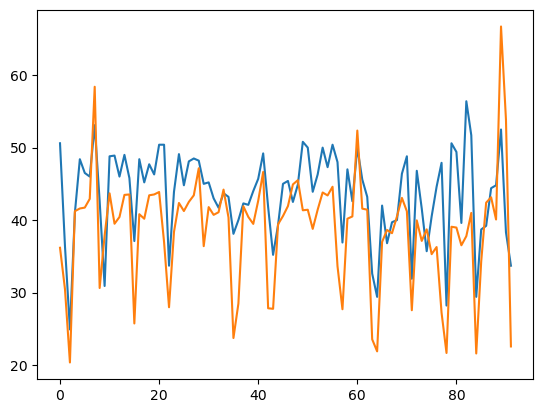

In [167]:
plt.plot(np.array(y_test))
plt.plot(y_pred)
plt.show()